In [1]:
'''
1. データの読み込みと前処理
'''
import os
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ダウンロード先のディレクトリ
root = './data'

# トランスフォーマーオブジェクトを生成
transform = transforms.Compose(
    [transforms.ToTensor(), # Tensorオブジェクトに変換
     transforms.Normalize((0.5), (0.5)) # 平均0.5、標準偏差0.5で正規化
     ])

# 訓練用データの読み込み(60000セット)
f_mnist_train = datasets.FashionMNIST(
    root=root,     # データの保存先のディレクトリ
    download=True, # ダウンロードを許可
    train=True,    # 訓練データを指定
    transform=transform) # トランスフォーマーオブジェクトを指定

# テスト用データの読み込み(10000セット)
f_mnist_test = datasets.FashionMNIST(
    root=root,     # データの保存先のディレクトリ
    download=True, # ダウンロードを許可
    train=False,   # テストデータを指定
    transform=transform) # トランスフォーマーオブジェクトを指定

# ミニバッチのサイズ
batch_size = 64
# 訓練用のデータローダー
train_dataloader = DataLoader(f_mnist_train, # 訓練データ
                              batch_size=batch_size, # ミニバッチのサイズ
                              shuffle=True) # シャッフルして抽出
# テスト用のデータローダー
test_dataloader = DataLoader(f_mnist_test, # テストデータ
                             batch_size=batch_size, # ミニバッチのサイズ
                             shuffle=False) # シャッフルして抽出

# データローダーが返すミニバッチの先頭データの形状を出力
for (x, t) in train_dataloader: # 訓練データ
    print(x.shape)
    print(t.shape)
    break

for (x, t) in test_dataloader: # テストデータ
    print(x.shape)
    print(t.shape)
    break

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 1, 28, 28])
torch.Size([64])





In [2]:
'''
2. モデルの定義
'''
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    '''畳み込みニューラルネットワーク
    
    '''
    def __init__(self):
        '''モデルの初期化を行う
        
        '''
        # スーパークラスの__init__()を実行
        super().__init__()
        # 畳み込み層1
        self.conv1 = nn.Conv2d(in_channels=1,   # 入力チャネル数
                               out_channels=32, # 出力チャネル数
                               kernel_size=3,   # フィルターサイズ
                               padding=(1,1),   # パディングを行う
                               padding_mode='zeros')# ゼロでパディング
        self.dropout1 = nn.Dropout2d(0.5)

        # 畳み込み層2
        self.conv2 = nn.Conv2d(in_channels=32,  # 入力チャネル数
                               out_channels=64, # 出力チャネル数
                               kernel_size=3,   # フィルターサイズ
                               padding=(1,1),   # パディングを行う
                               padding_mode='zeros')# ゼロでパディング
        self.dropout2 = nn.Dropout2d(0.5)

        # 全結合層1
        self.fc1 = nn.Linear(in_features=28*28*64, # 入力はフラット化後のサイズ
                             out_features=128)     # ニューロン数
        self.dropout3 = nn.Dropout(0.5)

        # 全結合層
        self.fc2 = nn.Linear(in_features=128, # 入力のサイズは前層のニューロン数
                             out_features=10) # ニューロン数はクラス数と同数
        
    def forward(self, x):
        '''MLPの順伝播処理を行う
        
        Parameters:
          x(ndarray(float32)):訓練データ、または検証データ
          
        Returns(float32):
          出力層からの出力値    
        '''
        x = torch.relu(self.conv1(x)) # 畳み込み層1の出力にReLUを適用
        x = self.dropout1(x)          # ドロップアウト1を適用
        x = F.relu(self.conv2(x))     # 畳み込み層2の出力にReLUを適用
        x = self.dropout2(x)          # ドロップアウト2を適用
        x = x.view(-1, 28 * 28 * 64)  # (バッチサイズ, 28, 28, 64)を
                                      # (バッチサイズ, 50176)にフラット化
        x = F.relu(self.fc1(x))       # 全結合層1の出力にReLUを適用
        x = self.dropout3(x)          # ドロップアウト3を適用
        x = self.fc2(x)               # 最終出力は活性化関数を適用しない
        return x

In [3]:
'''
3. モデルの生成
'''
import torch

# 使用可能なデバイス(CPUまたはGPU）を取得する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# モデルオブジェクトを生成し、使用可能なデバイスを設定する
model = CNN().to(device)

model # モデルの構造を出力

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [4]:
'''
4. 損失関数とオプティマイザーの生成
'''
import torch.optim

# クロスエントロピー誤差のオブジェクトを生成
criterion = nn.CrossEntropyLoss()
# 勾配降下アルゴリズムを使用するオプティマイザーを生成
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [5]:
'''
5. train_step()関数の定義
'''
def train_step(x, t):
    '''バックプロパゲーションによるパラメーター更新を行う
    
    Parameters: x: 訓練データ
                t: 正解ラベル
                
    Returns:
      MLPの出力と正解ラベルのクロスエントロピー誤差
    '''
    model.train()    # モデルを訓練(学習)モードにする
    preds = model(x) # モデルの出力を取得
    loss = criterion(preds, t) # 出力と正解ラベルの誤差から損失を取得
    optimizer.zero_grad() # 勾配を0で初期化（累積してしまうため）
    loss.backward()  # 逆伝播の処理(自動微分による勾配計算)
    optimizer.step() # 勾配降下法の更新式を適用してバイアス、重みを更新

    return loss, preds 

In [6]:
'''
6. test_step()関数の定義
'''
def test_step(x, t):
    '''テストデータを入力して損失と予測値を返す
    
    Parameters: x: テストデータ
                t: 正解ラベル
    Returns:
      MLPの出力と正解ラベルのクロスエントロピー誤差
    '''
    model.eval()    # モデルを評価モードにする
    preds = model(x) # モデルの出力を取得
    loss = criterion(preds, t) # 出力と正解ラベルの誤差から損失を取得

    return loss, preds 

In [7]:
'''
7. 学習の進捗を監視し早期終了判定を行うクラス
'''
class EarlyStopping:
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数(デフォルトは10)
            verbose(int): 早期終了の出力フラグ
                          出力(1),出力しない(0)        
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメーターで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメーターで初期化
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Return:
            True:監視回数の上限までに前エポックの損失を超えた場合
            False:監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            self.epoch += 1 # カウンターを1増やす
            # 監視回数の上限に達した場合
            if self.epoch > self.patience:
                if self.verbose: # 早期終了のフラグが1の場合
                    print('early stopping') # メッセージを出力
                return True # 学習を終了するTrueを返す
        # 前エポックの損失以下の場合
        else:
            self.epoch = 0               # カウンターを0に戻す
            self.pre_loss = current_loss # 損失の値を更新する
        
        # 監視回数の上限までに前エポックの損失を超えなければ
        # Falseを返して学習を続行する
        # 前エポックの損失を上回るが監視回数の範囲内であれば
        # Falseを返す必要があるので、return文の位置はここであることに注意
        return False

In [8]:
%%time
'''
8.モデルを使用して学習する
'''
from sklearn.metrics import accuracy_score

# エポック数
epochs = 100
# 損失と精度の履歴を保存するためのdictオブジェクト
history = {'loss':[],'accuracy':[], 'test_loss':[], 'test_accuracy':[]}
# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=5, # 監視対象回数
                    verbose=1)  # 早期終了時にメッセージを出力
# 学習を行う
for epoch in range(epochs):
    train_loss = 0. # 訓練1エポックあたりの損失を保持する変数
    train_acc = 0.  # 訓練1エポックごとの精度を保持する変数
    test_loss = 0. # 評価1エポックごとの損失を保持する変数
    test_acc = 0.  # 評価1エポックごとの精度を保持する変数

    # 1ステップにおける訓練用ミニバッチを使用した学習
    for (x, t) in train_dataloader:
        # torch.Tensorオブジェクトにデバイスを割り当てる
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t) # 損失と予測値を取得
        train_loss += loss.item()      # ステップごとの損失を加算
        train_acc += accuracy_score(
            t.tolist(),
            preds.argmax(dim=-1).tolist()
        )                              # ステップごとの精度を加算

    # 1ステップにおけるテストデータのミニバッチを使用した評価
    for (x, t) in test_dataloader:
        # torch.Tensorオブジェクトにデバイスを割り当てる
        x, t = x.to(device), t.to(device)
        loss, preds = test_step(x, t) # 損失と予測値を取得
        test_loss += loss.item()       # ステップごとの損失を加算
        test_acc += accuracy_score(
            t.tolist(),
            preds.argmax(dim=-1).tolist()
        )                              # ステップごとの精度を加算

    # 訓練時の損失の平均値を取得
    avg_train_loss = train_loss / len(train_dataloader)
    # 訓練時の精度の平均値を取得
    avg_train_acc = train_acc / len(train_dataloader)
    # 検証時の損失の平均値を取得
    avg_test_loss = test_loss / len(test_dataloader)
    # 検証時の精度の平均値を取得
    avg_test_acc = test_acc / len(test_dataloader)

    # 訓練データの履歴を保存する
    history['loss'].append(avg_train_loss)
    history['accuracy'].append(avg_train_acc)
    # テストデータの履歴を保存する
    history['test_loss'].append(avg_test_loss)
    history['test_accuracy'].append(avg_test_acc)

    # 1エポックごとに結果を出力
    if (epoch + 1) % 1 == 0:
        print(
            'epoch({}) train_loss: {:.4} train_acc: {:.4} val_loss: {:.4} val_acc: {:.4}'.format(
                epoch+1,
                avg_train_loss, # 訓練データの損失を出力
                avg_train_acc,  # 訓練データの精度を出力
                avg_test_loss,  # テストデータの損失を出力
                avg_test_acc    # テストデータの精度を出力
    ))
    
    # 検証データの損失をEarlyStoppingオブジェクトに渡して早期終了を判定
    if ers(avg_test_loss):
        # 監視対象のエポックで損失が改善されなければ学習を終了
        break

epoch(1) train_loss: 0.8672 train_acc: 0.6903 val_loss: 0.5375 val_acc: 0.8011
epoch(2) train_loss: 0.5798 train_acc: 0.7941 val_loss: 0.4636 val_acc: 0.831
epoch(3) train_loss: 0.5162 train_acc: 0.8167 val_loss: 0.4169 val_acc: 0.8496
epoch(4) train_loss: 0.4735 train_acc: 0.831 val_loss: 0.4081 val_acc: 0.8501
epoch(5) train_loss: 0.4483 train_acc: 0.8405 val_loss: 0.3843 val_acc: 0.8621
epoch(6) train_loss: 0.4236 train_acc: 0.8503 val_loss: 0.3667 val_acc: 0.8692
epoch(7) train_loss: 0.4108 train_acc: 0.8534 val_loss: 0.3553 val_acc: 0.8717
epoch(8) train_loss: 0.3964 train_acc: 0.8584 val_loss: 0.3462 val_acc: 0.8736
epoch(9) train_loss: 0.3804 train_acc: 0.8638 val_loss: 0.3375 val_acc: 0.8751
epoch(10) train_loss: 0.3717 train_acc: 0.8683 val_loss: 0.3275 val_acc: 0.8804
epoch(11) train_loss: 0.3653 train_acc: 0.8693 val_loss: 0.3319 val_acc: 0.8815
epoch(12) train_loss: 0.3538 train_acc: 0.8723 val_loss: 0.3146 val_acc: 0.8856
epoch(13) train_loss: 0.3485 train_acc: 0.8749 val_

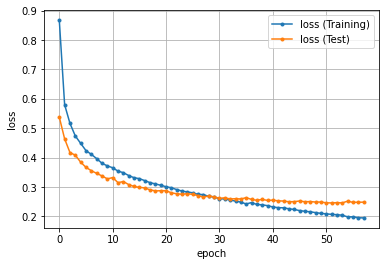

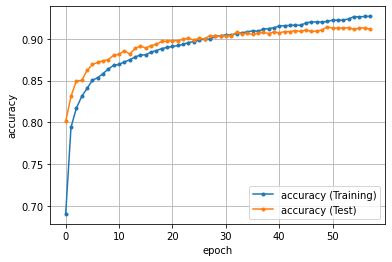

In [9]:
'''
9. 損失と精度の推移をグラフにする
'''
import matplotlib.pyplot as plt
%matplotlib inline

# 損失
plt.plot(history['loss'],
         marker='.',
         label='loss (Training)')
plt.plot(history['test_loss'],
         marker='.',
         label='loss (Test)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 精度
plt.plot(history['accuracy'],
         marker='.',
         label='accuracy (Training)')
plt.plot(history['test_accuracy'],
         marker='.',
         label='accuracy (Test)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()